# Traveling Salesman Problem

This example shows how an optimization can be used to solve a Traveling Salesman Problem over a roadmap.

## Roadmap Generation

For this example, we'll use the same Delaunay approach as before to generate a roadmap.  *Any* method that produces a set of paths and a distance matrix will work for TSP though.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial import Delaunay

Define a workspace in terms of four corners, and introduce some obstacles represented as polygons.  Then plot the world, including a handy utility for plotting closed polygons.

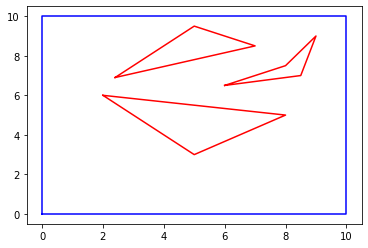

In [2]:
outer_points = np.array([[0.,0.],[0.,10.],[10.,10.],[10.0,0.0]])
obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.,6.5],[8.5,7.],[9.,9.],[8.,7.5]])]
obstacles.append(np.array([[2.4,6.9],[7.,8.5],[5.,9.5]]))
def plot_poly(points,fmt='b-',**kwargs):
    plt.plot(np.append(points[:,0],points[0,0]),np.append(points[:,1],points[0,1]),fmt)
plot_poly(outer_points)
for ob in obstacles:
    plot_poly(ob,'r-')
plt.show()

Take all vertices together - those of the workspace and of the obstacles - and run a Delaunay triangulation.  Plot it over our world to see if the edges line up.

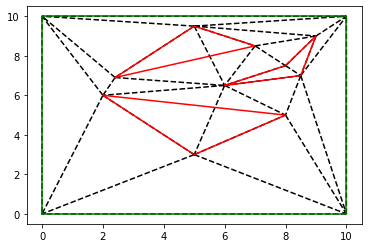

In [3]:
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
all_points = outer_points
obst_edges = set([])
for ob in obstacles:
    all_points = np.append(all_points,ob[:],0)
    num_ob_points = len(ob)
    for ii in range(num_ob_points):
        new_edge = (len(all_points)-num_ob_points+ii,len(all_points)-num_ob_points+(ii+1)%num_ob_points)
        obst_edges.add((min(new_edge),max(new_edge)))
tri = Delaunay(all_points)
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

They don't!  The long edge of the lower obstacle has been missed.  Identify the missing edges as those in the set of obstacle edges that are not included in the triangle edges.

In [4]:
tri_edges = set([(min(a,b),max(a,b)) for (a,b,c) in tri.simplices])
tri_edges = tri_edges.union(set([(min(a,c),max(a,c)) for (a,b,c) in tri.simplices]))
tri_edges = tri_edges.union(set([(min(c,b),max(c,b)) for (a,b,c) in tri.simplices]))
missed_edges = obst_edges-tri_edges
print(missed_edges)

{(4, 5), (11, 12)}


To correct the problem, take each missed edge and split it in two, adding the mid point to the set of all points and including the two new edges created in the set of obstacle edges.

In [5]:
for prob_edge in missed_edges:
    obst_edges.discard(prob_edge)
    new_point = 0.5*all_points[min(prob_edge)]+0.5*all_points[max(prob_edge)]
    all_points=np.append(all_points,[new_point],0)
    obst_edges.add((min(prob_edge),len(all_points)-1))
    obst_edges.add((max(prob_edge),len(all_points)-1))
    
print(obst_edges)
print(all_points)

{(12, 15), (4, 6), (5, 6), (12, 13), (4, 14), (8, 9), (9, 10), (5, 14), (7, 10), (11, 15), (7, 8), (11, 13)}
[[ 0.   0. ]
 [ 0.  10. ]
 [10.  10. ]
 [10.   0. ]
 [ 2.   6. ]
 [ 8.   5. ]
 [ 5.   3. ]
 [ 6.   6.5]
 [ 8.5  7. ]
 [ 9.   9. ]
 [ 8.   7.5]
 [ 2.4  6.9]
 [ 7.   8.5]
 [ 5.   9.5]
 [ 5.   5.5]
 [ 4.7  7.7]]


Now repeat the triangulation

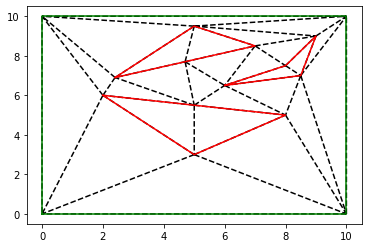

In [6]:
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')

tri = Delaunay(all_points)
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

Now repeat the edge test and verify that all obstacle edges are in the triangle edges set.

> For proper algorithm, would need to repeat adding midpoints until all edges were captured.

In [7]:
tri_edges = set([(min(a,b),max(a,b)) for (a,b,c) in tri.simplices])
tri_edges = tri_edges.union(set([(min(a,c),max(a,c)) for (a,b,c) in tri.simplices]))
tri_edges = tri_edges.union(set([(min(c,b),max(c,b)) for (a,b,c) in tri.simplices]))
assert(obst_edges.issubset(tri_edges))
print('Got this far, so must have caught all edges OK now')

Got this far, so must have caught all edges OK now


Now to build the roadmap.  The triangulation tells us help neighbour information about each triangle.  We will include an 'entry/exit' point for each pair of neighbouring triangles if their shared edge isn't an obstacle edge.  We'll also build a distance matrix as we go, capturing the distance between entry/exit points across their common triangle. 

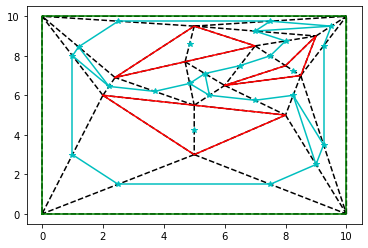

In [8]:
num_tris = len(tri.simplices)

nx_points = []
d = np.inf+np.zeros((num_tris,num_tris))
tri_nx = [[] for t in tri.simplices]
new_nx_idx = 0

for ii in range(num_tris):
    for jj in tri.neighbors[ii]:
        if jj>ii:
            common_edge = set(tri.simplices[ii]).intersection(set(tri.simplices[jj]))
            # ignore neighbour if the common edge is an obstacle edge
            if (min(common_edge),max(common_edge)) in obst_edges:
                pass
            else:
                mid_point = sum(all_points[list(common_edge)])/2.0
                #print(mid_point)
                plt.plot(mid_point[0],mid_point[1],'c*')
                nx_points.append(mid_point)
                new_nx_idx = len(nx_points)-1
                tri_nx[ii].append(new_nx_idx)
                tri_nx[jj].append(new_nx_idx)
                for nx in tri_nx[ii]:
                    d[new_nx_idx,nx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    d[nx,new_nx_idx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    plt.plot([nx_points[nx][0],nx_points[new_nx_idx][0]],[nx_points[nx][1],nx_points[new_nx_idx][1]],'c-')
                for nx in tri_nx[jj]:
                    d[new_nx_idx,nx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    d[nx,new_nx_idx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    plt.plot([nx_points[nx][0],nx_points[new_nx_idx][0]],[nx_points[nx][1],nx_points[new_nx_idx][1]],'c-')

num_nx_points = len(nx_points)
d = d[0:num_nx_points,0:num_nx_points]
                    
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

That's the roadmap done, and the distance matrix.  Next, 

Ready for the graph search on the roadmap now.

In [9]:
from scipy.sparse.csgraph import shortest_path
distance,predecessors = shortest_path(d, return_predecessors=True)
print(distance)
print(predecessors)

[[ 0.          5.         12.33092052  7.33092052 14.45224086 10.87989289
          inf  9.07711725  3.04634084  8.04634084  8.96776782  6.98682849
   8.50751912  5.76924892  6.83847763         inf  2.01556444  0.70710678
   6.17232231  5.06214214  7.69301294  3.84456258  1.82514077         inf
   2.72652859]
 [ 5.          0.          7.33092052  2.33092052  9.45224086 14.45224086
          inf 14.07230688  8.04634084 13.04634084 10.49285162  5.59523624
   4.07454561  6.81281581  1.83847763         inf  7.01556444  5.70710678
   7.69740611  7.51992259  9.21809674  8.73750215  6.82514077         inf
   7.72652859]
 [12.33092052  7.33092052  0.          5.          2.12132034  7.12132034
          inf  8.92409598 14.95487239  9.95487239 12.50355125  8.48092021
   6.96022958  9.69849978  5.49244289         inf 14.34648496 13.0380273
  10.58309008 10.40560656 12.10378071 11.62318612 13.64260793         inf
  12.74122011]
 [ 7.33092052  2.33092052  5.          0.          7.12132034 12.121

## The TSP bit

Now we've built the roadmap, instead of running an A-to-B search like Dijkstra's on it, let's choose a set of nodes, and find the shortest path that visits all of them...

Start by picking those nodes and drawing the paths that join them all.

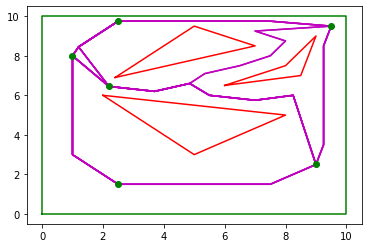

In [10]:
tsp_nodes = [1, 3, 4, 7, 12,16]

def get_path(start_idx,goal_idx):
    idx_list = [start_idx]
    pts_list = [nx_points[start_idx]]
    for kk in range(len(nx_points)):
        next_node = predecessors[goal_idx,idx_list[-1]]
        idx_list.append(next_node)
        pts_list.append(nx_points[next_node])
        if next_node==goal_idx:
            break
    return(np.array(pts_list),idx_list)

for ii in tsp_nodes:
    for jj in tsp_nodes:
        if ii!=jj:
            pp,px = get_path(ii,jj)
            plt.plot(pp[:,0],pp[:,1],'m-')
            
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.plot([nx_points[i][0] for i in tsp_nodes], [nx_points[i][1] for i in tsp_nodes], 'go')
plt.show()

In [11]:
from pulp import *
n = len(tsp_nodes)
links = [(i,j) for i in tsp_nodes for j in tsp_nodes if j!=i]

prob = LpProblem('tsp',LpMinimize)
x = LpVariable.dicts("x",links,0,1,LpInteger)
prob.setObjective(sum([distance[i,j]*x[i,j] for (i,j) in links]))
for i in tsp_nodes:
    prob += (sum(x[ic,j] for (ic,j) in links if ic==i)==1)
for j in tsp_nodes:
    prob += (sum(x[i,jc] for (i,jc) in links if jc==j)==1)

v = LpVariable.dicts("v",tsp_nodes,0,n)
for (i,j) in links:
    if j!=tsp_nodes[0]:
        prob += (v[j]>=v[i]+1-n*(1-x[i,j]))

prob 

tsp:
MINIMIZE
4.074545608584813*x_(1,_12) + 7.015564437074637*x_(1,_16) + 2.3309205211748285*x_(1,_3) + 9.45224086473447*x_(1,_4) + 14.072306884787505*x_(1,_7) + 4.074545608584813*x_(12,_1) + 10.312881247784295*x_(12,_16) + 1.9602295783912658*x_(12,_3) + 9.081549921950907*x_(12,_4) + 9.997761276202692*x_(12,_7) + 7.015564437074637*x_(16,_1) + 10.312881247784295*x_(16,_12) + 9.346484958249466*x_(16,_3) + 13.864328450540825*x_(16,_4) + 7.061552812808831*x_(16,_7) + 2.3309205211748285*x_(3,_1) + 1.9602295783912658*x_(3,_12) + 9.346484958249466*x_(3,_16) + 7.121320343559642*x_(3,_4) + 11.957990854593959*x_(3,_7) + 9.45224086473447*x_(4,_1) + 9.081549921950907*x_(4,_12) + 13.864328450540825*x_(4,_16) + 7.121320343559642*x_(4,_3) + 6.802775637731995*x_(4,_7) + 14.072306884787505*x_(7,_1) + 9.997761276202692*x_(7,_12) + 7.061552812808831*x_(7,_16) + 11.957990854593959*x_(7,_3) + 6.802775637731995*x_(7,_4) + 0.0
SUBJECT TO
_C1: x_(1,_12) + x_(1,_16) + x_(1,_3) + x_(1,_4) + x_(1,_7) = 1

_C2: x

In [12]:
prob.solve()
print("Status:", LpStatus[prob.status])
[(i,j,x[i,j].value()) for (i,j) in links]

Status: Optimal


[(1, 3, 0.0),
 (1, 4, 0.0),
 (1, 7, 0.0),
 (1, 12, 0.0),
 (1, 16, 1.0),
 (3, 1, 0.0),
 (3, 4, 0.0),
 (3, 7, 0.0),
 (3, 12, 1.0),
 (3, 16, 0.0),
 (4, 1, 0.0),
 (4, 3, 1.0),
 (4, 7, 0.0),
 (4, 12, 0.0),
 (4, 16, 0.0),
 (7, 1, 0.0),
 (7, 3, 0.0),
 (7, 4, 1.0),
 (7, 12, 0.0),
 (7, 16, 0.0),
 (12, 1, 1.0),
 (12, 3, 0.0),
 (12, 4, 0.0),
 (12, 7, 0.0),
 (12, 16, 0.0),
 (16, 1, 0.0),
 (16, 3, 0.0),
 (16, 4, 0.0),
 (16, 7, 1.0),
 (16, 12, 0.0)]

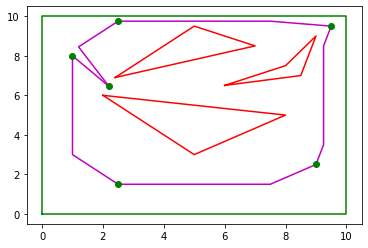

In [13]:
for (ii,jj) in links:
    if x[ii,jj].value()==1.:
        pp,px = get_path(ii,jj)
        plt.plot(pp[:,0],pp[:,1],'m-')
            
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.plot([nx_points[i][0] for i in tsp_nodes], [nx_points[i][1] for i in tsp_nodes], 'go')
plt.show()